<a href="https://colab.research.google.com/github/Chengeng-Yang/ML_projects/blob/main/AF2Rank_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AF2Rank
[AF2Rank](https://github.com/jproney/AF2Rank) implemented using ColabDesign.

If you find useful, please cite:
- Roney, J.P. and Ovchinnikov, S., 2022. **State-of-the-Art estimation of protein model accuracy using AlphaFold**. [BioRxiv](https://www.biorxiv.org/content/10.1101/2022.03.11.484043v3.full).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title ## setup
%%bash
if [ ! -d params ]; then
  # get code
  pip -q install git+https://github.com/sokrypton/ColabDesign.git@v1.1.1
  # for debugging
  ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign

  # alphafold params
  mkdir params
  curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar | tar x -C params

  wget -qnc https://zhanggroup.org/TM-score/TMscore.cpp
  g++ -static -O3 -ffast-math -lm -o TMscore TMscore.cpp
fi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.7 MB/s eta 0:00:00


In [ ]:
#@title import libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from colabdesign import clear_mem, mk_af_model
from colabdesign.shared.utils import copy_dict

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import jax

def tmscore(x,y):
  # save to dumpy pdb files
  for n,z in enumerate([x,y]):
    out = open(f"{n}.pdb","w")
    for k,c in enumerate(z):
      out.write("ATOM  %5d  %-2s  %3s %s%4d    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n"
                  % (k+1,"CA","ALA","A",k+1,c[0],c[1],c[2],1,0))
    out.close()
  # pass to TMscore
  output = os.popen('./TMscore 0.pdb 1.pdb')

  # parse outputs
  parse_float = lambda x: float(x.split("=")[1].split()[0])
  o = {}
  for line in output:
    line = line.rstrip()
    if line.startswith("RMSD"): o["rms"] = parse_float(line)
    if line.startswith("TM-score"): o["tms"] = parse_float(line)
    if line.startswith("GDT-TS-score"): o["gdt"] = parse_float(line)

  return o

def plot_me(scores, x="tm_i", y="composite",
            title=None, diag=False, scale_axis=True, dpi=100, **kwargs):
  def rescale(a,amin=None,amax=None):
    a = np.copy(a)
    if amin is None: amin = a.min()
    if amax is None: amax = a.max()
    a[a < amin] = amin
    a[a > amax] = amax
    return (a - amin)/(amax - amin)

  plt.figure(figsize=(5,5), dpi=dpi)
  if title is not None: plt.title(title)
  x_vals = np.array([k[x] for k in scores])
  y_vals = np.array([k[y] for k in scores])
  c = rescale(np.array([k["plddt"] for k in scores]),0.5,0.9)
  plt.scatter(x_vals, y_vals, c=c*0.75, s=5, vmin=0, vmax=1, cmap="gist_rainbow",
              **kwargs)
  if diag:
    plt.plot([0,1],[0,1],color="black")

  labels = {"tm_i":"TMscore of Input",
            "tm_o":"TMscore of Output",
            "tm_io":"TMscore between Input and Output",
            "ptm":"Predicted TMscore (pTM)",
            "i_ptm":"Predicted interface TMscore (ipTM)",
            "plddt":"Predicted LDDT (pLDDT)",
            "composite":"Composite"}

  plt.xlabel(labels.get(x,x));  plt.ylabel(labels.get(y,y))
  if scale_axis:
    if x in labels: plt.xlim(-0.1, 1.1)
    if y in labels: plt.ylim(-0.1, 1.1)

  print(spearmanr(x_vals,y_vals).correlation)

class af2rank:
  def __init__(self, pdb, chain=None, model_name="model_1_ptm", model_names=None):
    self.args = {"pdb":pdb, "chain":chain,
                 "use_multimer":("multimer" in model_name),
                 "model_name":model_name,
                 "model_names":model_names}
    self.reset()

  def reset(self):
    self.model = mk_af_model(protocol="fixbb",
                             use_templates=True,
                             use_multimer=self.args["use_multimer"],
                             debug=False,
                             model_names=self.args["model_names"])

    self.model.prep_inputs(self.args["pdb"], chain=self.args["chain"])
    self.model.set_seq(mode="wildtype")
    self.wt_batch = copy_dict(self.model._inputs["batch"])
    self.wt = self.model._wt_aatype

  def set_pdb(self, pdb, chain=None):
    if chain is None: chain = self.args["chain"]
    self.model.prep_inputs(pdb, chain=chain)
    self.model.set_seq(mode="wildtype")
    self.wt = self.model._wt_aatype

  def set_seq(self, seq):
    self.model.set_seq(seq=seq)
    self.wt = self.model._params["seq"][0].argmax(-1)

  def _get_score(self):
    score = copy_dict(self.model.aux["log"])

    score["plddt"] = score["plddt"]
    score["pae"] = 31.0 * score["pae"]
    score["rmsd_io"] = score.pop("rmsd",None)

    i_xyz = self.model._inputs["batch"]["all_atom_positions"][:,1]
    o_xyz = np.array(self.model.aux["atom_positions"][:,1])

    # TMscore to input/output
    if hasattr(self,"wt_batch"):
      n_xyz = self.wt_batch["all_atom_positions"][:,1]
      score["tm_i"] = tmscore(n_xyz,i_xyz)["tms"]
      score["tm_o"] = tmscore(n_xyz,o_xyz)["tms"]

    # TMscore between input and output
    score["tm_io"] = tmscore(i_xyz,o_xyz)["tms"]

    # composite score
    score["composite"] = score["ptm"] * score["plddt"] * score["tm_io"]
    return score

  def predict(self, pdb=None, seq=None, chain=None,
              input_template=True, model_name=None,
              rm_seq=True, rm_sc=True, rm_ic=False,
              recycles=1, iterations=1,
              output_pdb=None, extras=None, verbose=True):

    if model_name is not None:
      self.args["model_name"] = model_name
      if "multimer" in model_name:
        if not self.args["use_multimer"]:
          self.args["use_multimer"] = True
          self.reset()
      else:
        if self.args["use_multimer"]:
          self.args["use_multimer"] = False
          self.reset()

    if pdb is not None: self.set_pdb(pdb, chain)
    if seq is not None: self.set_seq(seq)

    # set template sequence
    self.model._inputs["batch"]["aatype"] = self.wt

    # set other options
    self.model.set_opt(
        template=dict(rm_ic=rm_ic),
        num_recycles=recycles)
    self.model._inputs["rm_template"][:] = not input_template
    self.model._inputs["rm_template_sc"][:] = rm_sc
    self.model._inputs["rm_template_seq"][:] = rm_seq

    # "manual" recycles using templates
    ini_atoms = self.model._inputs["batch"]["all_atom_positions"].copy()
    for i in range(iterations):
      self.model.predict(models=self.args["model_name"], verbose=False)
      if i < iterations - 1:
        self.model._inputs["batch"]["all_atom_positions"] = self.model.aux["atom_positions"]
      else:
        self.model._inputs["batch"]["all_atom_positions"] = ini_atoms

    score = self._get_score()
    if extras is not None:
      score.update(extras)

    if output_pdb is not None:
      self.model.save_pdb(output_pdb)

    if verbose:
      print_list = ["tm_i","tm_o","tm_io","composite","ptm","i_ptm","plddt","fitness","id"]
      print_score = lambda k: f"{k} {score[k]:.4f}" if isinstance(score[k],float) else f"{k} {score[k]}"
      print(*[print_score(k) for k in print_list if k in score])

    return score

In [ ]:
#@markdown ### **settings**
recycles = 1 #@param ["0", "1", "2", "3", "4"] {type:"raw"}
iterations = 1

# decide what model to use
model_mode = "alphafold-multimer" #@param ["alphafold", "alphafold-multimer"]
model_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}

if model_mode == "alphafold":
  model_name = f"model_{model_num}_ptm"
if model_mode == "alphafold-multimer":
  model_name = f"model_{model_num}_multimer_v3"

save_output_pdbs = True #@param {type:"boolean"}

#@markdown ### **advanced**
mask_sequence = True #@param {type:"boolean"}
mask_sidechains = True #@param {type:"boolean"}
mask_interchain = False #@param {type:"boolean"}

SETTINGS = {"rm_seq":mask_sequence,
            "rm_sc":mask_sidechains,
            "rm_ic":mask_interchain,
            "recycles":int(recycles),
            "iterations":int(iterations),
            "model_name":model_name}

## rank structures

In [ ]:
NAME = "4m3k"
CHAIN = "A,B" # this can be multiple  #change from A to B
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output", exist_ok=True) #ok_exists=True)


# get data from rcsb; no decoy
%shell wget -qnc https://files.rcsb.org/download/{NAME}.pdb


# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])

af.predict(pdb=NATIVE_PATH, **SETTINGS, extras={"id":NATIVE_PATH})

tm_i 1.0000 tm_o 0.7436 tm_io 0.7436 composite 0.3985 ptm 0.6551 i_ptm 0.1002 plddt 0.8180 id 4m3k.pdb


{'con': 1.5922664403915405,
 'dgram_cce': 0.7734336853027344,
 'exp_res': 0.0024014548398554325,
 'fape': 0.5252897143363953,
 'hard': 1.0,
 'helix': 4.22415828704834,
 'i_ptm': 0.1001817062497139,
 'loss': 0.7734336853027344,
 'models': [0],
 'pae': 4.545825764536858,
 'plddt': 0.8179619908332825,
 'ptm': 0.6551194190979004,
 'recycles': 1,
 'seq_ent': 1014.6396484375,
 'seqid': 1.0,
 'soft': 0.0,
 'temp': 1.0,
 'rmsd_io': 11.548102378845215,
 'tm_i': 1.0,
 'tm_o': 0.7436,
 'tm_io': 0.7436,
 'composite': 0.3984675663897619,
 'id': '4m3k.pdb'}

In [ ]:
NAME = "1mjc"
CHAIN = "A" # this can be multiple chains
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"

if save_output_pdbs:
  os.makedirs(f"{NAME}_output",ok_exists=True)


# get data
%shell wget -qnc https://files.ipd.uw.edu/pub/decoyset/natives/{NAME}.pdb
%shell wget -qnc https://files.ipd.uw.edu/pub/decoyset/decoys/{NAME}.zip
%shell unzip -qqo {NAME}.zip

# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])

In [ ]:
# score no structure
_ = af.predict(pdb=NATIVE_PATH, input_template=False, **SETTINGS)

tm_i 1.0000 tm_o 0.6650 tm_io 0.6650 composite 0.2399 ptm 0.5467 i_ptm 0.0000 plddt 0.6599


In [ ]:
SCORES = []

# score native structure
SCORES.append(af.predict(pdb=NATIVE_PATH, **SETTINGS, extras={"id":NATIVE_PATH}))

# score the decoy sctructures
for decoy_pdb in os.listdir(DECOY_DIR):
  input_pdb = os.path.join(DECOY_DIR, decoy_pdb)
  if save_output_pdbs:
    output_pdb = os.path.join(f"{NAME}_output",decoy_pdb)
  else:
    output_pdb = None
  SCORES.append(af.predict(pdb=input_pdb, output_pdb=output_pdb,
                           **SETTINGS, extras={"id":decoy_pdb}))

0.9286667300616703


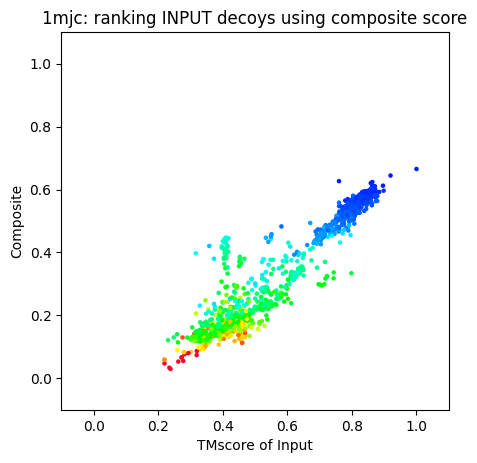

In [ ]:
plot_me(SCORES, x="tm_i", y="composite",
        title=f"{NAME}: ranking INPUT decoys using composite score")

0.9143006449691364


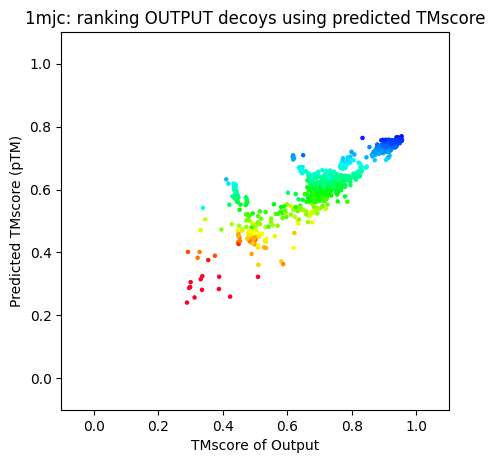

In [ ]:
plot_me(SCORES, x="tm_o", y="ptm",
        title=f"{NAME}: ranking OUTPUT decoys using predicted TMscore")

0.8287990333595944


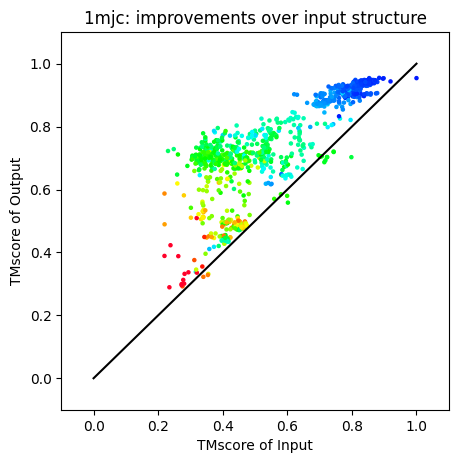

In [ ]:
plot_me(SCORES, x="tm_i", y="tm_o", diag=True,
        title=f"{NAME}: improvements over input structure")

## rank sequences
Example: ParD and ParE are an example of a toxin and antitoxin pair of proteins. If the pair of proteins bind, the organism survives, if they do not, organism does not! Mike Laub et al. created a library of mutants that targets this interface and their measured "fitness". Let's see how well AlphaFold can predict this, using the template trick.

In [ ]:
# get data
%shell wget -qnc https://files.ipd.uw.edu/krypton/5CEG_AD_trim.pdb
%shell wget -qnc https://files.ipd.uw.edu/krypton/design/Library_fitness_vs_parE3_replicate_A.csv
%shell wget -qnc https://files.ipd.uw.edu/krypton/design/Library_fitness_vs_parE3_replicate_B.csv

# lets parse the data
lib_a = dict([line.rstrip().split(",") for line in open("Library_fitness_vs_parE3_replicate_A.csv")])
lib_b = dict([line.rstrip().split(",") for line in open("Library_fitness_vs_parE3_replicate_B.csv")])
lib_ab = jax.tree_map(lambda a,b:(float(a)+float(b))/2,lib_a,lib_b)

# get sequences
seqs = {}
for mut,sco in lib_ab.items():
  seq = list("RHDDIRRLRQLWDEGKASGRPEPVDFDALRKEARQKLTEVRLVWSPTAKADLIDIYVMIGSENIRAADRYYDQLEARALQLADQPRMGVRRPDIRPSARMLVEAPFVLLYETVPDTDDGPVEWVEIVRVVDGRRDLNRLF")
  # mutate seq
  for i,m in zip([10,11,12,15],list(mut)): seq[i] = m
  seq = "".join(seq)
  seqs[mut] = {"seq":seq, "sco":sco}

NAME = "toxin"
if save_output_pdbs:
  os.makedirs(f"{NAME}_output",ok_exists=True)


In [ ]:
# setup model
clear_mem()
af = af2rank("5CEG_AD_trim.pdb", chain="A,B", model_name=SETTINGS["model_name"])
SCORES,LABELS = [],[]

In [ ]:
for label,x in seqs.items():
  if label not in LABELS:

    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output",f"{label}.pdb")
    else:
      output_pdb = None

    score = af.predict(seq=x["seq"], **SETTINGS, output_pdb=output_pdb,
                       extras={"fitness":x["sco"], "id":label})
    SCORES.append(score)
    LABELS.append(label)

In [ ]:
plot_me(SCORES, x="fitness", y="composite", scale_axis=False)

## test 4m3k


### zdock 2.1, created by 3.0.2

In [ ]:
NAME = "4m3k"
CHAIN = "A" # this can be multiple  #change from A to B
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output", exist_ok=True) #ok_exists=True)


# get data from rcsb; no decoy
%shell wget -qnc https://files.rcsb.org/download/{NAME}.pdb


# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
# note 230425, reset is problematic

In [ ]:
# score no structure
_ = af.predict(pdb=NATIVE_PATH, input_template=False, **SETTINGS)

tm_i 1.0000 tm_o 0.4811 tm_io 0.4811 composite 0.0607 ptm 0.3343 i_ptm 0.0000 plddt 0.3774


In [ ]:
SCORES = []

# score native structure
SCORES.append(af.predict(pdb=NATIVE_PATH, **SETTINGS, extras={"id":NATIVE_PATH}))


In [ ]:
# scp the pose folder from Kevin's server
%shell scp conda@dz8-kcy8-dsa:zdock2.1_linux_64bit/poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip ./
%shell unzip -qqo poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip

In [ ]:
# upload poses_4m3k_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip from local instead; but the file will be deleted when the runtime is ended
%shell tar xvzf drive/MyDrive/poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip

#### score all poses

In [ ]:
# score poses
import csv

with open('demo_4m3k_2.1_B.csv', 'w') as myFile:
  writer = csv.writer(myFile)
  writer.writerow(['con', 'dgram_cce', 'exp_res', 'fape', 'hard', 'helix', 'i_ptm','loss', 'models', 'pae', 'plddt', 'ptm', 'recycles', 'seq_ent', 'seqid', 'soft', 'temp', 'rmsd_io', 'tm_i', 'tm_o', 'tm_io', 'composite', 'id'
])

SCORES = []
POSE_DIR = f"poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2/"
for pose_pdb in os.listdir(POSE_DIR):
  if 'complex' in pose_pdb:
    input_pdb = os.path.join(POSE_DIR, pose_pdb)
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
    else:
      output_pdb = None
    SCORES.append(af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb}))
    with open('demo_4m3k_2.1_B.csv', 'a') as myFile:
      writer = csv.writer(myFile)
      writer.writerow(SCORES[-1].values())
    %shell cp demo_4m3k_2.1_B.csv drive/MyDrive/demo_4m3k_2.1_B.csv

tm_i 1.0000 tm_o 0.9686 tm_io 0.9686 composite 0.8064 ptm 0.8703 i_ptm 0.0000 plddt 0.9566 id complex.1109.pdb
tm_i 1.0000 tm_o 0.9686 tm_io 0.9686 composite 0.8064 ptm 0.8703 i_ptm 0.0000 plddt 0.9566 id complex.1444.pdb
tm_i 1.0000 tm_o 0.9686 tm_io 0.9686 composite 0.8064 ptm 0.8703 i_ptm 0.0000 plddt 0.9566 id complex.5.pdb
tm_i 1.0000 tm_o 0.9686 tm_io 0.9686 composite 0.8064 ptm 0.8703 i_ptm 0.0000 plddt 0.9566 id complex.549.pdb
tm_i 1.0000 tm_o 0.9686 tm_io 0.9686 composite 0.8064 ptm 0.8703 i_ptm 0.0000 plddt 0.9566 id complex.371.pdb
tm_i 1.0000 tm_o 0.9686 tm_io 0.9686 composite 0.8064 ptm 0.8703 i_ptm 0.0000 plddt 0.9566 id complex.787.pdb
tm_i 1.0000 tm_o 0.9686 tm_io 0.9686 composite 0.8064 ptm 0.8703 i_ptm 0.0000 plddt 0.9566 id complex.1961.pdb
tm_i 1.0000 tm_o 0.9686 tm_io 0.9686 composite 0.8064 ptm 0.8703 i_ptm 0.0000 plddt 0.9566 id complex.1396.pdb
tm_i 1.0000 tm_o 0.9686 tm_io 0.9686 composite 0.8064 ptm 0.8703 i_ptm 0.0000 plddt 0.9566 id complex.986.pdb
tm_i 1.0

In [ ]:
# save SCORES to csv # test
import csv

myFile = open('demo_4m3k.csv', 'w')
writer = csv.writer(myFile)
writer.writerow(['tm_i','tm_o', 'tm_io', 'composite', 'ptm', 'i_ptm', 'plddt', 'id'])
for dictionary in SCORES:
    writer.writerow(dictionary.values())
myFile.close()


#### use AF2Rank to score complexes with the top 5, medium 5 and lowest 5 zdock scores; also compare with the pose generated by abdockgen

##### rHlA

###### single chain

In [ ]:
NAME = "4m3k"
CHAIN = "A" # this can be multiple  #change from A to B
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output", exist_ok=True) #ok_exists=True)


# get data from rcsb; no decoy
%shell wget -qnc https://files.rcsb.org/download/{NAME}.pdb


# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
# note 230425, reset is problematic

In [ ]:
# upload poses_4m3k_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip from local instead; but the file will be deleted when the runtime is ended
%shell tar xvzf drive/MyDrive/poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip

In [ ]:
## zdock score
POSE_DIR = f"poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2/"
top = range(1,6)
medium = range(998,1003)
bottom = range(1996,2001)
tierlist = [top,medium,bottom]
tierlist_str = ['top','medium','bottom']

for tier in range(len(tierlist)):
  print('score of ',tierlist_str[tier], '5 poses:')
  for num in tierlist[tier]:
    pose_pdb = f'complex.{num}.pdb'
    input_pdb = f'{POSE_DIR}/complex.{num}.pdb'
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
    else:
      output_pdb = None
    af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb})



score of  top 5 poses:
tm_i 1.0000 tm_o 0.9897 tm_io 0.9897 composite 0.8539 ptm 0.9099 i_ptm 0.0000 plddt 0.9482 id complex.1.pdb
tm_i 1.0000 tm_o 0.9898 tm_io 0.9898 composite 0.8542 ptm 0.9100 i_ptm 0.0000 plddt 0.9483 id complex.2.pdb
tm_i 1.0000 tm_o 0.9898 tm_io 0.9898 composite 0.8538 ptm 0.9098 i_ptm 0.0000 plddt 0.9481 id complex.3.pdb
tm_i 1.0000 tm_o 0.9898 tm_io 0.9898 composite 0.8541 ptm 0.9100 i_ptm 0.0000 plddt 0.9483 id complex.4.pdb
tm_i 1.0000 tm_o 0.9897 tm_io 0.9897 composite 0.8540 ptm 0.9100 i_ptm 0.0000 plddt 0.9483 id complex.5.pdb
score of  medium 5 poses:
tm_i 1.0000 tm_o 0.9897 tm_io 0.9897 composite 0.8540 ptm 0.9100 i_ptm 0.0000 plddt 0.9482 id complex.998.pdb
tm_i 1.0000 tm_o 0.9898 tm_io 0.9898 composite 0.8539 ptm 0.9099 i_ptm 0.0000 plddt 0.9482 id complex.999.pdb
tm_i 1.0000 tm_o 0.9897 tm_io 0.9897 composite 0.8537 ptm 0.9098 i_ptm 0.0000 plddt 0.9481 id complex.1000.pdb
tm_i 1.0000 tm_o 0.9896 tm_io 0.9896 composite 0.8539 ptm 0.9099 i_ptm 0.0000 pl

In [ ]:
# abdockgen
# pose_pdb = f'4m3k_B_A_bindingseq_chain-match-sample.pdb'
# input_pdb = f'4m3k_B_A_bindingseq_chain-match-sample.pdb'
pose_pdb = f'4m3k_B_A_pred_sample-ckpt.pdb'
input_pdb = f'4m3k_B_A_pred_sample-ckpt.pdb'
if save_output_pdbs:
  output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
else:
  output_pdb = None
af.predict(pdb=input_pdb, output_pdb=output_pdb,
                        **SETTINGS, extras={"id":pose_pdb})

tm_i 0.7982 tm_o 0.8076 tm_io 0.9861 composite 0.8587 ptm 0.9134 i_ptm 0.0000 plddt 0.9534 id 4m3k_B_A_pred_sample-ckpt.pdb


{'con': 0.8482070565223694,
 'dgram_cce': 1.1633045673370361,
 'exp_res': 0.0009422175935469568,
 'fape': 0.34512099623680115,
 'hard': 1.0,
 'helix': 5.154178142547607,
 'i_ptm': 0.0,
 'loss': 1.1633045673370361,
 'models': [0],
 'pae': 3.139632999897003,
 'plddt': 0.9533663392066956,
 'ptm': 0.91341233253479,
 'recycles': 1,
 'seq_ent': 705.3644409179688,
 'seqid': 1.0,
 'soft': 0.0,
 'temp': 1.0,
 'rmsd_io': 0.7177258729934692,
 'tm_i': 0.7982,
 'tm_o': 0.8076,
 'tm_io': 0.9861,
 'composite': 0.858712221308938,
 'id': '4m3k_B_A_pred_sample-ckpt.pdb'}

###### chain A,B

In [ ]:
## zdock
NAME = "4m3k"
CHAIN = "A,B" # this can be multiple  #change from A to B
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output", exist_ok=True) #ok_exists=True)


# get data from rcsb; no decoy
%shell wget -qnc https://files.rcsb.org/download/{NAME}.pdb


# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
# note 230425, reset is problematic

In [ ]:
# upload poses_4m3k_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip from local instead; but the file will be deleted when the runtime is ended
%shell tar xvzf drive/MyDrive/poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip

In [ ]:
af.predict(pdb=NATIVE_PATH, **SETTINGS, extras={"id":NATIVE_PATH}) #test

tm_i 1.0000 tm_o 0.7436 tm_io 0.7436 composite 0.3985 ptm 0.6551 i_ptm 0.1002 plddt 0.8180 id 4m3k.pdb


{'con': 1.5922664403915405,
 'dgram_cce': 0.7734336853027344,
 'exp_res': 0.0024014548398554325,
 'fape': 0.5252897143363953,
 'hard': 1.0,
 'helix': 4.22415828704834,
 'i_ptm': 0.1001817062497139,
 'loss': 0.7734336853027344,
 'models': [0],
 'pae': 4.545825764536858,
 'plddt': 0.8179619908332825,
 'ptm': 0.6551194190979004,
 'recycles': 1,
 'seq_ent': 1014.6396484375,
 'seqid': 1.0,
 'soft': 0.0,
 'temp': 1.0,
 'rmsd_io': 11.548102378845215,
 'tm_i': 1.0,
 'tm_o': 0.7436,
 'tm_io': 0.7436,
 'composite': 0.3984675663897619,
 'id': '4m3k.pdb'}

In [ ]:
## zdock score
POSE_DIR = f"poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2/"
top = range(1,6)
medium = range(998,1003)
bottom = range(1996,2001)
tierlist = [top,medium,bottom]
tierlist_str = ['top','medium','bottom']

for tier in range(len(tierlist)):
  print('score of ',tierlist_str[tier], '5 poses:')
  for num in tierlist[tier]:
    pose_pdb = f'complex.{num}.pdb'
    input_pdb = f'{POSE_DIR}/complex.{num}.pdb'
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
    else:
      output_pdb = None
    af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb})



score of  top 5 poses:
tm_i 0.7008 tm_o 0.7432 tm_io 0.6909 composite 0.3702 ptm 0.6544 i_ptm 0.0966 plddt 0.8188 id complex.1.pdb
tm_i 0.7009 tm_o 0.7441 tm_io 0.6984 composite 0.3744 ptm 0.6544 i_ptm 0.0966 plddt 0.8191 id complex.2.pdb


KeyboardInterrupt: ignored

In [ ]:
# abdockgen #use a different native; chain name = A,H
NAME = "4m3k"
CHAIN = "A,H" # this can be multiple  #change from A to B
NATIVE_PATH = f'4m3k_B_A_bindingseq_chain-match-sample.pdb'
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output", exist_ok=True) #ok_exists=True)

# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
# note 230425, reset is problematic


%shell cp drive/MyDrive/4m3k_B_A_bindingseq_chain-match-sample_edited.pdb ./
pose_pdb =  '4m3k_B_A_pred_sample-ckpt.pdb'
input_pdb = '4m3k_B_A_pred_sample-ckpt.pdb'
if save_output_pdbs:
  output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
else:
  output_pdb = None
af.predict(pdb=input_pdb,
           output_pdb=output_pdb,
                        **SETTINGS, extras={"id":pose_pdb})

tm_i 0.8007 tm_o 0.7932 tm_io 0.9382 composite 0.7331 ptm 0.8836 i_ptm 0.3133 plddt 0.8843 id 4m3k_B_A_pred_sample-ckpt.pdb


{'con': 1.4765971899032593,
 'dgram_cce': 1.070410966873169,
 'exp_res': 0.0323721207678318,
 'fape': 0.40577933192253113,
 'hard': 1.0,
 'helix': 4.184812068939209,
 'i_ptm': 0.3133479356765747,
 'loss': 1.070410966873169,
 'models': [0],
 'pae': 3.6233732998371124,
 'plddt': 0.8843065276741982,
 'ptm': 0.8835690021514893,
 'recycles': 1,
 'seq_ent': 743.3455810546875,
 'seqid': 1.0,
 'soft': 0.0,
 'temp': 1.0,
 'rmsd_io': 10.394646644592285,
 'tm_i': 0.8007,
 'tm_o': 0.7932,
 'tm_io': 0.9382,
 'composite': 0.7330586635726956,
 'id': '4m3k_B_A_pred_sample-ckpt.pdb'}

In [ ]:
ls drive/MyDrive/4m3k_B_A_bindingseq_chain-match-sample_edited.pdb

drive/MyDrive/4m3k_B_A_bindingseq_chain-match-sample_edited.pdb


### zdock3.0.2

In [ ]:
# upload poses_4m3k.zip from local, the file will be deleted when the runtime is ended
%shell tar xvzf drive/MyDrive/poses_{NAME}.zip

##### scire all poses

In [ ]:
# score poses & write scores
import csv

with open('drive/MyDrive/demo_4m3k_3.0.2_B.csv', 'w') as myFile:
  writer = csv.writer(myFile)
  writer.writerow(['con', 'dgram_cce', 'exp_res', 'fape', 'hard', 'helix', 'i_ptm','loss', 'models', 'pae', 'plddt', 'ptm', 'recycles', 'seq_ent', 'seqid', 'soft', 'temp', 'rmsd_io', 'tm_i', 'tm_o', 'tm_io', 'composite', 'id'
])

SCORES = []
POSE_DIR = f"poses_{NAME}/"
for pose_pdb in os.listdir(POSE_DIR):
  if 'complex' in pose_pdb:
    input_pdb = os.path.join(POSE_DIR, pose_pdb)
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
    else:
      output_pdb = None

    SCORES.append(af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb}))
    #print('testing output ',SCORES[-1].values())
    with open('drive/MyDrive/demo_4m3k_3.0.2_B.csv', 'a') as myFile:
      writer = csv.writer(myFile)
      writer.writerow(SCORES[-1].values())
   # %shell cp demo_4m3k_3.0.2_B.csv drive/MyDrive/demo_4m3k_3.0.2_B.csv


tm_i 1.0000 tm_o 0.9686 tm_io 0.9686 composite 0.8064 ptm 0.8703 i_ptm 0.0000 plddt 0.9566 id complex.1109.pdb
tm_i 1.0000 tm_o 0.9686 tm_io 0.9686 composite 0.8064 ptm 0.8703 i_ptm 0.0000 plddt 0.9566 id complex.1444.pdb
tm_i 1.0000 tm_o 0.9686 tm_io 0.9686 composite 0.8064 ptm 0.8703 i_ptm 0.0000 plddt 0.9566 id complex.5.pdb
tm_i 1.0000 tm_o 0.9686 tm_io 0.9686 composite 0.8064 ptm 0.8703 i_ptm 0.0000 plddt 0.9566 id complex.549.pdb
tm_i 1.0000 tm_o 0.9686 tm_io 0.9686 composite 0.8064 ptm 0.8703 i_ptm 0.0000 plddt 0.9566 id complex.371.pdb
tm_i 1.0000 tm_o 0.9686 tm_io 0.9686 composite 0.8064 ptm 0.8703 i_ptm 0.0000 plddt 0.9566 id complex.787.pdb
tm_i 1.0000 tm_o 0.9686 tm_io 0.9686 composite 0.8064 ptm 0.8703 i_ptm 0.0000 plddt 0.9566 id complex.1961.pdb
tm_i 1.0000 tm_o 0.9686 tm_io 0.9686 composite 0.8064 ptm 0.8703 i_ptm 0.0000 plddt 0.9566 id complex.1396.pdb
tm_i 1.0000 tm_o 0.9686 tm_io 0.9686 composite 0.8064 ptm 0.8703 i_ptm 0.0000 plddt 0.9566 id complex.986.pdb
tm_i 1.0

In [ ]:
# score poses & write scores (cont.) #read csv and skip the one that has been in the csv file
import pandas as pd
import csv

myFile = 'drive/MyDrive/demo_4m3k_3.0.2_B.csv'
table = pd.read_table(myFile,delimiter=',')
cmplx_df = table['id']

%shell cp drive/MyDrive/demo_4m3k_3.0.2_B.csv drive/MyDrive/demo_4m3k_3.0.2_B_copy.csv

SCORES = []
POSE_DIR = f"poses_{NAME}/"
for pose_pdb in os.listdir(POSE_DIR):
  if 'complex' in pose_pdb and pose_pdb not in cmplx_df.to_numpy():
    input_pdb = os.path.join(POSE_DIR, pose_pdb)
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
    else:
      output_pdb = None

    SCORES.append(af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb}))
    #print('testing output ',SCORES[-1].values())
    with open('drive/MyDrive/demo_4m3k_3.0.2_B.csv', 'a') as myFile:
      writer = csv.writer(myFile)
      writer.writerow(SCORES[-1].values())
   # %shell cp demo_4m3k_3.0.2_B.csv drive/MyDrive/demo_4m3k_3.0.2_B.csv

tm_i 1.0000 tm_o 0.9690 tm_io 0.9690 composite 0.8073 ptm 0.8703 i_ptm 0.0000 plddt 0.9572 id complex.1155.pdb
tm_i 1.0000 tm_o 0.9690 tm_io 0.9690 composite 0.8073 ptm 0.8703 i_ptm 0.0000 plddt 0.9572 id complex.651.pdb
tm_i 1.0000 tm_o 0.9690 tm_io 0.9690 composite 0.8073 ptm 0.8703 i_ptm 0.0000 plddt 0.9572 id complex.170.pdb
tm_i 1.0000 tm_o 0.9690 tm_io 0.9690 composite 0.8073 ptm 0.8703 i_ptm 0.0000 plddt 0.9572 id complex.1090.pdb
tm_i 1.0000 tm_o 0.9690 tm_io 0.9690 composite 0.8073 ptm 0.8703 i_ptm 0.0000 plddt 0.9572 id complex.820.pdb
tm_i 1.0000 tm_o 0.9690 tm_io 0.9690 composite 0.8073 ptm 0.8703 i_ptm 0.0000 plddt 0.9572 id complex.1851.pdb
tm_i 1.0000 tm_o 0.9690 tm_io 0.9690 composite 0.8073 ptm 0.8703 i_ptm 0.0000 plddt 0.9572 id complex.1354.pdb
tm_i 1.0000 tm_o 0.9690 tm_io 0.9690 composite 0.8073 ptm 0.8703 i_ptm 0.0000 plddt 0.9572 id complex.1172.pdb
tm_i 1.0000 tm_o 0.9690 tm_io 0.9690 composite 0.8073 ptm 0.8703 i_ptm 0.0000 plddt 0.9572 id complex.100.pdb
tm_i 

In [ ]:
# import pandas as pd
# myFile = 'drive/MyDrive/demo_4m3k_3.0.2_B.csv'
# table = pd.read_table(myFile,delimiter=',')
# cmplx_df = table['id']
['complex.1109.pdb'] in cmplx_df.to_numpy()

True

In [ ]:
import csv

myFile = open('demo_4m3k.csv', 'w')
writer = csv.writer(myFile)
writer.writerow(['tm_i','tm_o', 'tm_io', 'composite', 'ptm', 'i_ptm', 'plddt', 'id'])
for dictionary in SCORES:
    writer.writerow(dictionary.values())
myFile.close()

#### use AF2Rank to score complexes with the top 5, medium 5 and lowest 5 zdock scores; also compare with the pose generated by abdockgen

##### rHlA

###### single chain

In [ ]:
NAME = "4m3k"
CHAIN = "A" # this can be multiple  #change from A to B
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output_3.0.2", exist_ok=True) #ok_exists=True)


# get data from rcsb; no decoy
%shell wget -qnc https://files.rcsb.org/download/{NAME}.pdb


# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
# note 230425, reset is problematic

In [ ]:
# upload poses_4m3k.zip from local; but the file will be deleted when the runtime is ended
%shell tar xvzf drive/MyDrive/poses_{NAME}.zip

In [ ]:
## zdock score
POSE_DIR = f"poses_{NAME}/"
top = range(1,6)
medium = range(998,1003)
bottom = range(1996,2001)
tierlist = [top,medium,bottom]
tierlist_str = ['top','medium','bottom']

for tier in range(len(tierlist)):
  print('score of ',tierlist_str[tier], '5 poses:')
  for num in tierlist[tier]:
    pose_pdb = f'complex.{num}.pdb'
    input_pdb = f'{POSE_DIR}/complex.{num}.pdb'
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output_3.0.2",pose_pdb)
    else:
      output_pdb = None
    af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb})



score of  top 5 poses:
tm_i 1.0000 tm_o 0.9898 tm_io 0.9898 composite 0.8540 ptm 0.9099 i_ptm 0.0000 plddt 0.9482 id complex.1.pdb
tm_i 1.0000 tm_o 0.9898 tm_io 0.9898 composite 0.8542 ptm 0.9099 i_ptm 0.0000 plddt 0.9484 id complex.2.pdb
tm_i 1.0000 tm_o 0.9897 tm_io 0.9897 composite 0.8540 ptm 0.9100 i_ptm 0.0000 plddt 0.9482 id complex.3.pdb
tm_i 1.0000 tm_o 0.9898 tm_io 0.9898 composite 0.8541 ptm 0.9099 i_ptm 0.0000 plddt 0.9483 id complex.4.pdb
tm_i 1.0000 tm_o 0.9898 tm_io 0.9898 composite 0.8541 ptm 0.9100 i_ptm 0.0000 plddt 0.9483 id complex.5.pdb
score of  medium 5 poses:
tm_i 1.0000 tm_o 0.9897 tm_io 0.9897 composite 0.8540 ptm 0.9100 i_ptm 0.0000 plddt 0.9483 id complex.998.pdb
tm_i 1.0000 tm_o 0.9898 tm_io 0.9898 composite 0.8543 ptm 0.9100 i_ptm 0.0000 plddt 0.9484 id complex.999.pdb
tm_i 1.0000 tm_o 0.9897 tm_io 0.9897 composite 0.8537 ptm 0.9098 i_ptm 0.0000 plddt 0.9482 id complex.1000.pdb
tm_i 1.0000 tm_o 0.9898 tm_io 0.9898 composite 0.8542 ptm 0.9101 i_ptm 0.0000 pl

###### chain A,B

In [ ]:
## zdock
NAME = "4m3k"
CHAIN = "A,B" # this can be multiple  #change from A to B
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output_3.0.2", exist_ok=True) #ok_exists=True)


# get data from rcsb; no decoy
%shell wget -qnc https://files.rcsb.org/download/{NAME}.pdb


# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
# note 230425, reset is problematic

In [ ]:
# upload poses_4m3k from local; but the file will be deleted when the runtime is ended
%shell tar xvzf drive/MyDrive/poses_{NAME}.zip

In [ ]:
## zdock score
POSE_DIR = f"poses_{NAME}/"
top = range(1,6)
medium = range(998,1003)
bottom = range(1996,2001)
tierlist = [top,medium,bottom]
tierlist_str = ['top','medium','bottom']

for tier in range(len(tierlist)):
  print('score of ',tierlist_str[tier], '5 poses:')
  for num in tierlist[tier]:
    pose_pdb = f'complex.{num}.pdb'
    input_pdb = f'{POSE_DIR}/complex.{num}.pdb'
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output_3.0.2",pose_pdb)
    else:
      output_pdb = None
    af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb})



score of  top 5 poses:
tm_i 0.6981 tm_o 0.7441 tm_io 0.6943 composite 0.3733 ptm 0.6555 i_ptm 0.0982 plddt 0.8203 id complex.1.pdb
tm_i 0.7045 tm_o 0.7423 tm_io 0.6954 composite 0.3739 ptm 0.6559 i_ptm 0.1007 plddt 0.8198 id complex.2.pdb
tm_i 0.6980 tm_o 0.7435 tm_io 0.6940 composite 0.3731 ptm 0.6554 i_ptm 0.0974 plddt 0.8204 id complex.3.pdb
tm_i 0.6985 tm_o 0.7443 tm_io 0.6942 composite 0.3728 ptm 0.6550 i_ptm 0.0977 plddt 0.8199 id complex.4.pdb
tm_i 0.6993 tm_o 0.7427 tm_io 0.6937 composite 0.3728 ptm 0.6557 i_ptm 0.1003 plddt 0.8196 id complex.5.pdb
score of  medium 5 poses:
tm_i 0.6947 tm_o 0.7406 tm_io 0.6892 composite 0.3691 ptm 0.6541 i_ptm 0.0953 plddt 0.8187 id complex.998.pdb
tm_i 0.7096 tm_o 0.7428 tm_io 0.7048 composite 0.3781 ptm 0.6549 i_ptm 0.0978 plddt 0.8192 id complex.999.pdb
tm_i 0.7475 tm_o 0.7448 tm_io 0.7521 composite 0.4036 ptm 0.6550 i_ptm 0.0979 plddt 0.8192 id complex.1000.pdb
tm_i 0.6970 tm_o 0.7430 tm_io 0.6955 composite 0.3730 ptm 0.6552 i_ptm 0.0978 pl

In [ ]:
ls drive/MyDrive/4m3k_B_A_bindingseq_chain-match-sample_edited.pdb

drive/MyDrive/4m3k_B_A_bindingseq_chain-match-sample_edited.pdb


#### use AF2Rank to score complexes with the top 5, medium 5 and lowest 5 zrank scores; also compare with the pose generated by abdockgen

##### rHlA

###### single chain

In [ ]:
NAME = "4m3k"
CHAIN = "A" # this can be multiple  #change from A to B
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output_3.0.2", exist_ok=True) #ok_exists=True)


# get data from rcsb; no decoy
%shell wget -qnc https://files.rcsb.org/download/{NAME}.pdb


# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
# note 230425, reset is problematic

In [ ]:
# upload poses_4m3k.zip from local; but the file will be deleted when the runtime is ended
%shell tar xvzf drive/MyDrive/poses_{NAME}.zip

In [ ]:
POSE_DIR = f"poses_{NAME}/"
top = [384,1716,64,893,1363]
medium = [507,1117,261,286,279]
bottom = [75,1460,1266,518,1319]
tierlist = [top,medium,bottom]
tierlist_str = ['top','medium','bottom']

for tier in range(len(tierlist)):
  print('score of ',tierlist_str[tier], '5 poses:')
  for num in tierlist[tier]:
    pose_pdb = f'complex.{num}.pdb'
    input_pdb = f'{POSE_DIR}/complex.{num}.pdb'
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output_3.0.2",pose_pdb)
    else:
      output_pdb = None
    af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb})

score of  top 5 poses:
tm_i 1.0000 tm_o 0.9896 tm_io 0.9896 composite 0.8529 ptm 0.9090 i_ptm 0.0000 plddt 0.9481 id complex.384.pdb
tm_i 1.0000 tm_o 0.9897 tm_io 0.9897 composite 0.8533 ptm 0.9095 i_ptm 0.0000 plddt 0.9481 id complex.1716.pdb
tm_i 1.0000 tm_o 0.9896 tm_io 0.9896 composite 0.8527 ptm 0.9090 i_ptm 0.0000 plddt 0.9479 id complex.64.pdb
tm_i 1.0000 tm_o 0.9899 tm_io 0.9899 composite 0.8534 ptm 0.9093 i_ptm 0.0000 plddt 0.9481 id complex.893.pdb
tm_i 1.0000 tm_o 0.9897 tm_io 0.9897 composite 0.8532 ptm 0.9093 i_ptm 0.0000 plddt 0.9480 id complex.1363.pdb
score of  medium 5 poses:
tm_i 1.0000 tm_o 0.9894 tm_io 0.9894 composite 0.8524 ptm 0.9087 i_ptm 0.0000 plddt 0.9480 id complex.507.pdb
tm_i 1.0000 tm_o 0.9897 tm_io 0.9897 composite 0.8529 ptm 0.9090 i_ptm 0.0000 plddt 0.9481 id complex.1117.pdb
tm_i 1.0000 tm_o 0.9900 tm_io 0.9900 composite 0.8536 ptm 0.9094 i_ptm 0.0000 plddt 0.9481 id complex.261.pdb
tm_i 1.0000 tm_o 0.9897 tm_io 0.9897 composite 0.8533 ptm 0.9093 i_pt

###### chain A,B

In [ ]:
## zdock
NAME = "4m3k"
CHAIN = "A,B" # this can be multiple  #change from A to B
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output_3.0.2", exist_ok=True) #ok_exists=True)


# get data from rcsb; no decoy
%shell wget -qnc https://files.rcsb.org/download/{NAME}.pdb


# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
# note 230425, reset is problematic

In [ ]:
# upload poses_4m3k from local; but the file will be deleted when the runtime is ended
%shell tar xvzf drive/MyDrive/poses_{NAME}.zip

poses_4m3k/
poses_4m3k/create_lig
poses_4m3k/create.pl
poses_4m3k/zdock_4m3k_B_A_mda_marked_rHlA.out
poses_4m3k/complex.81.pdb
poses_4m3k/complex.1.pdb
poses_4m3k/complex.82.pdb
poses_4m3k/complex.2.pdb
poses_4m3k/complex.83.pdb
poses_4m3k/complex.3.pdb
poses_4m3k/complex.84.pdb
poses_4m3k/complex.4.pdb
poses_4m3k/complex.85.pdb
poses_4m3k/complex.5.pdb
poses_4m3k/complex.86.pdb
poses_4m3k/complex.6.pdb
poses_4m3k/complex.87.pdb
poses_4m3k/complex.7.pdb
poses_4m3k/complex.88.pdb
poses_4m3k/complex.8.pdb
poses_4m3k/complex.89.pdb
poses_4m3k/complex.9.pdb
poses_4m3k/complex.41.pdb
poses_4m3k/complex.10.pdb
poses_4m3k/complex.42.pdb
poses_4m3k/complex.11.pdb
poses_4m3k/complex.43.pdb
poses_4m3k/complex.12.pdb
poses_4m3k/complex.45.pdb
poses_4m3k/complex.13.pdb
poses_4m3k/complex.44.pdb
poses_4m3k/complex.14.pdb
poses_4m3k/complex.46.pdb
poses_4m3k/complex.15.pdb
poses_4m3k/complex.47.pdb
poses_4m3k/complex.16.pdb
poses_4m3k/complex.48.pdb
poses_4m3k/complex.17.pdb
poses_4m3k/complex.49.pd

In [ ]:
## zdock score
POSE_DIR = f"poses_{NAME}/"
top = [384,1716,64,893,1363]
medium = [507,1117,261,286,279]
bottom = [75,1460,1266,518,1319]
tierlist = [top,medium,bottom]
tierlist_str = ['top','medium','bottom']

for tier in range(len(tierlist)):
  print('score of ',tierlist_str[tier], '5 poses:')
  for num in tierlist[tier]:
    pose_pdb = f'complex.{num}.pdb'
    input_pdb = f'{POSE_DIR}/complex.{num}.pdb'
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output_3.0.2",pose_pdb)
    else:
      output_pdb = None
    af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb})



score of  top 5 poses:
tm_i 0.6968 tm_o 0.7443 tm_io 0.6933 composite 0.3723 ptm 0.6554 i_ptm 0.0981 plddt 0.8193 id complex.384.pdb
tm_i 0.7343 tm_o 0.7422 tm_io 0.7044 composite 0.3770 ptm 0.6545 i_ptm 0.0982 plddt 0.8178 id complex.1716.pdb
tm_i 0.6986 tm_o 0.7443 tm_io 0.6954 composite 0.3731 ptm 0.6550 i_ptm 0.0963 plddt 0.8192 id complex.64.pdb
tm_i 0.6958 tm_o 0.7353 tm_io 0.6891 composite 0.3684 ptm 0.6537 i_ptm 0.0952 plddt 0.8178 id complex.893.pdb
tm_i 0.7296 tm_o 0.7435 tm_io 0.7061 composite 0.3782 ptm 0.6544 i_ptm 0.0972 plddt 0.8186 id complex.1363.pdb
score of  medium 5 poses:
tm_i 0.6980 tm_o 0.7109 tm_io 0.7001 composite 0.3769 ptm 0.6564 i_ptm 0.1029 plddt 0.8202 id complex.507.pdb
tm_i 0.6962 tm_o 0.7356 tm_io 0.6922 composite 0.3709 ptm 0.6541 i_ptm 0.0957 plddt 0.8191 id complex.1117.pdb
tm_i 0.6970 tm_o 0.7234 tm_io 0.6924 composite 0.3718 ptm 0.6551 i_ptm 0.0991 plddt 0.8196 id complex.261.pdb
tm_i 0.6986 tm_o 0.7240 tm_io 0.6991 composite 0.3766 ptm 0.6562 i_pt

In [ ]:
## zdock score
POSE_DIR = f"poses_{NAME}/"
top = [384,1716,64,893,1363]
medium = [507,1117,261,286,279]
bottom = [75,1460,1266,518,1319]
tierlist = [top,medium,bottom]
tierlist_str = ['top','medium','bottom']

for tier in range(len(tierlist))[2:]:
  print('score of ',tierlist_str[tier], '5 poses:')
  for num in tierlist[tier][1:]:
    pose_pdb = f'complex.{num}.pdb'
    input_pdb = f'{POSE_DIR}/complex.{num}.pdb'
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output_3.0.2",pose_pdb)
    else:
      output_pdb = None
    af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb})



score of  bottom 5 poses:
tm_i 0.7383 tm_o 0.7425 tm_io 0.7236 composite 0.3883 ptm 0.6548 i_ptm 0.0970 plddt 0.8196 id complex.1460.pdb
tm_i 0.6963 tm_o 0.7371 tm_io 0.6941 composite 0.3715 ptm 0.6541 i_ptm 0.0957 plddt 0.8183 id complex.1266.pdb
tm_i 0.6983 tm_o 0.7425 tm_io 0.6930 composite 0.3726 ptm 0.6558 i_ptm 0.0997 plddt 0.8197 id complex.518.pdb
tm_i 0.6998 tm_o 0.7448 tm_io 0.6972 composite 0.3749 ptm 0.6549 i_ptm 0.0956 plddt 0.8211 id complex.1319.pdb


In [ ]:
## zdock score
POSE_DIR = f"poses_{NAME}/"
top = [384,1716,64,893,1363]
medium = [507,1117,261,286,279]
bottom = [75,1460,1266,518,1319]
tierlist = [top,medium,bottom]
tierlist_str = ['top','medium','bottom']

for tier in range(len(tierlist)):
  print('score of ',tierlist_str[tier], '5 poses:')
  for num in tierlist[tier]:
    pose_pdb = f'complex.{num}.pdb'
    input_pdb = f'{POSE_DIR}/complex.{num}.pdb'
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output_3.0.2",pose_pdb)
    else:
      output_pdb = None
    af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb})



score of  top 5 poses:
tm_i 0.6968 tm_o 0.7442 tm_io 0.6936 composite 0.3721 ptm 0.6547 i_ptm 0.0967 plddt 0.8193 id complex.384.pdb
tm_i 0.7343 tm_o 0.7390 tm_io 0.7067 composite 0.3794 ptm 0.6552 i_ptm 0.0981 plddt 0.8194 id complex.1716.pdb
tm_i 0.6986 tm_o 0.7448 tm_io 0.6957 composite 0.3733 ptm 0.6550 i_ptm 0.0968 plddt 0.8191 id complex.64.pdb
tm_i 0.6958 tm_o 0.7370 tm_io 0.6892 composite 0.3694 ptm 0.6543 i_ptm 0.0959 plddt 0.8191 id complex.893.pdb
tm_i 0.7296 tm_o 0.7426 tm_io 0.7065 composite 0.3790 ptm 0.6545 i_ptm 0.0975 plddt 0.8196 id complex.1363.pdb
score of  medium 5 poses:
tm_i 0.6980 tm_o 0.7133 tm_io 0.6995 composite 0.3771 ptm 0.6563 i_ptm 0.1015 plddt 0.8215 id complex.507.pdb
tm_i 0.6962 tm_o 0.7354 tm_io 0.6923 composite 0.3723 ptm 0.6549 i_ptm 0.0955 plddt 0.8213 id complex.1117.pdb
tm_i 0.6970 tm_o 0.7251 tm_io 0.6923 composite 0.3732 ptm 0.6560 i_ptm 0.0993 plddt 0.8217 id complex.261.pdb
tm_i 0.6986 tm_o 0.7191 tm_io 0.7003 composite 0.3773 ptm 0.6561 i_pt

## test 6n51

### zdock 2.1, created by 3.0.2

In [ ]:
NAME = "6n51"
CHAIN = "A" # this can be multiple chains; testing A later
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output", exist_ok=True) #ok_exists=True)


# get data from rcsb; no decoy
%shell wget -qnc https://files.rcsb.org/download/{NAME}.pdb


# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
# note 230425, reset is problematic

In [ ]:
# score no structure
_ = af.predict(pdb=NATIVE_PATH, input_template=False, **SETTINGS)

tm_i 1.0000 tm_o 0.4811 tm_io 0.4811 composite 0.0607 ptm 0.3343 i_ptm 0.0000 plddt 0.3774


In [ ]:
SCORES = []

# score native structure
SCORES.append(af.predict(pdb=NATIVE_PATH, **SETTINGS, extras={"id":NATIVE_PATH}))


In [ ]:
# scp the pose folder from Kevin's server
%shell scp conda@dz8-kcy8-dsa:zdock2.1_linux_64bit/poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip ./
%shell unzip -qqo poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip

In [ ]:
# upload poses_6n51_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip from local instead; but the file will be deleted when the runtime is ended
%shell tar xvzf drive/MyDrive/poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip

#### score all poses

In [ ]:
# score poses
import csv

with open('demo_4m3k_2.1_B.csv', 'w') as myFile:
  writer = csv.writer(myFile)
  writer.writerow(['con', 'dgram_cce', 'exp_res', 'fape', 'hard', 'helix', 'i_ptm','loss', 'models', 'pae', 'plddt', 'ptm', 'recycles', 'seq_ent', 'seqid', 'soft', 'temp', 'rmsd_io', 'tm_i', 'tm_o', 'tm_io', 'composite', 'id'
])

SCORES = []
POSE_DIR = f"poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2/"
for pose_pdb in os.listdir(POSE_DIR):
  if 'complex' in pose_pdb:
    input_pdb = os.path.join(POSE_DIR, pose_pdb)
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
    else:
      output_pdb = None
    SCORES.append(af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb}))
    with open('demo_4m3k_2.1_B.csv', 'a') as myFile:
      writer = csv.writer(myFile)
      writer.writerow(SCORES[-1].values())
    %shell cp demo_4m3k_2.1_B.csv drive/MyDrive/demo_4m3k_2.1_B.csv

In [ ]:
!ls drive/MyDrive/


In [ ]:
# save SCORES to csv
import csv

myFile = open('demo_4m3k.csv', 'w')
writer = csv.writer(myFile)
writer.writerow(['tm_i','tm_o', 'tm_io', 'composite', 'ptm', 'i_ptm', 'plddt', 'id'])
for dictionary in SCORES:
    writer.writerow(dictionary.values())
myFile.close()


#### use AF2Rank to score complexes with the top 5, medium 5 and lowest 5 zdock scores; also compare with the pose generated by abdockgen

##### rHlA

###### single chain

In [ ]:
NAME = "6n51"
CHAIN = "A" # this can be multiple  #change from A to B
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output", exist_ok=True) #ok_exists=True)


# get data from rcsb; no decoy
%shell wget -qnc https://files.rcsb.org/download/{NAME}.pdb


# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
# note 230425, reset is problematic

In [ ]:
# upload poses_6n51_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip from local instead; but the file will be deleted when the runtime is ended
%shell tar xvzf drive/MyDrive/poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip

In [ ]:
## zdock score
POSE_DIR = f"poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2/"
top = range(1,6)
medium = range(998,1003)
bottom = range(1996,2001)
tierlist = [top,medium,bottom]
tierlist_str = ['top','medium','bottom']

for tier in range(len(tierlist)):
  print('score of ',tierlist_str[tier], '5 poses:')
  for num in tierlist[tier]:
    pose_pdb = f'complex.{num}.pdb'
    input_pdb = f'{POSE_DIR}/complex.{num}.pdb'
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
    else:
      output_pdb = None
    af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb})



score of  top 5 poses:
tm_i 1.0000 tm_o 0.9467 tm_io 0.9467 composite 0.5784 ptm 0.6817 i_ptm 0.0000 plddt 0.8962 id complex.1.pdb
tm_i 1.0000 tm_o 0.9473 tm_io 0.9473 composite 0.5788 ptm 0.6819 i_ptm 0.0000 plddt 0.8961 id complex.2.pdb
tm_i 1.0000 tm_o 0.9470 tm_io 0.9470 composite 0.5786 ptm 0.6818 i_ptm 0.0000 plddt 0.8962 id complex.3.pdb
tm_i 1.0000 tm_o 0.9472 tm_io 0.9472 composite 0.5789 ptm 0.6819 i_ptm 0.0000 plddt 0.8962 id complex.4.pdb
tm_i 1.0000 tm_o 0.9469 tm_io 0.9469 composite 0.5788 ptm 0.6821 i_ptm 0.0000 plddt 0.8963 id complex.5.pdb
score of  medium 5 poses:
tm_i 1.0000 tm_o 0.9478 tm_io 0.9478 composite 0.5791 ptm 0.6817 i_ptm 0.0000 plddt 0.8963 id complex.998.pdb
tm_i 1.0000 tm_o 0.9479 tm_io 0.9479 composite 0.5789 ptm 0.6815 i_ptm 0.0000 plddt 0.8962 id complex.999.pdb
tm_i 1.0000 tm_o 0.9476 tm_io 0.9476 composite 0.5789 ptm 0.6818 i_ptm 0.0000 plddt 0.8960 id complex.1000.pdb
tm_i 1.0000 tm_o 0.9475 tm_io 0.9475 composite 0.5786 ptm 0.6816 i_ptm 0.0000 pl

In [ ]:
## zdock score #re
POSE_DIR = f"poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2/"
top = range(1,6)
medium = range(998,1003)
bottom = range(1996,2001)
tierlist = [top,medium,bottom]
tierlist_str = ['top','medium','bottom']

for tier in range(len(tierlist)):
  print('score of ',tierlist_str[tier], '5 poses:')
  for num in tierlist[tier]:
    pose_pdb = f'complex.{num}.pdb'
    input_pdb = f'{POSE_DIR}/complex.{num}.pdb'
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
    else:
      output_pdb = None
    af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb})



score of  top 5 poses:
tm_i 1.0000 tm_o 0.9476 tm_io 0.9476 composite 0.5793 ptm 0.6820 i_ptm 0.0000 plddt 0.8963 id complex.1.pdb
tm_i 1.0000 tm_o 0.9477 tm_io 0.9477 composite 0.5789 ptm 0.6815 i_ptm 0.0000 plddt 0.8963 id complex.2.pdb
tm_i 1.0000 tm_o 0.9471 tm_io 0.9471 composite 0.5786 ptm 0.6818 i_ptm 0.0000 plddt 0.8960 id complex.3.pdb
tm_i 1.0000 tm_o 0.9471 tm_io 0.9471 composite 0.5791 ptm 0.6822 i_ptm 0.0000 plddt 0.8963 id complex.4.pdb
tm_i 1.0000 tm_o 0.9471 tm_io 0.9471 composite 0.5789 ptm 0.6819 i_ptm 0.0000 plddt 0.8963 id complex.5.pdb
score of  medium 5 poses:
tm_i 1.0000 tm_o 0.9479 tm_io 0.9479 composite 0.5794 ptm 0.6819 i_ptm 0.0000 plddt 0.8963 id complex.998.pdb
tm_i 1.0000 tm_o 0.9482 tm_io 0.9482 composite 0.5799 ptm 0.6823 i_ptm 0.0000 plddt 0.8963 id complex.999.pdb
tm_i 1.0000 tm_o 0.9476 tm_io 0.9476 composite 0.5790 ptm 0.6820 i_ptm 0.0000 plddt 0.8960 id complex.1000.pdb
tm_i 1.0000 tm_o 0.9476 tm_io 0.9476 composite 0.5794 ptm 0.6822 i_ptm 0.0000 pl

In [ ]:
# abdockgen

pose_pdb = f'{NAME}_C_A_pred_sample-ckpt.pdb'
input_pdb = f'{NAME}_C_A_pred_sample-ckpt.pdb'
if save_output_pdbs:
  output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
else:
  output_pdb = None
af.predict(pdb=input_pdb, output_pdb=output_pdb,
                        **SETTINGS, extras={"id":pose_pdb})

tm_i 1.0000 tm_o 0.9463 tm_io 0.9463 composite 0.5748 ptm 0.6796 i_ptm 0.0000 plddt 0.8938 id 6n51_C_A_pred_sample-ckpt.pdb


{'con': 1.5021681785583496,
 'dgram_cce': 0.34487614035606384,
 'exp_res': 0.03377602621912956,
 'fape': 0.6621382832527161,
 'hard': 1.0,
 'helix': 3.7704708576202393,
 'i_ptm': 0.0,
 'loss': 0.34487614035606384,
 'models': [0],
 'pae': 13.816061288118362,
 'plddt': 0.8938077688217163,
 'ptm': 0.6795623302459717,
 'recycles': 1,
 'seq_ent': 2145.935791015625,
 'seqid': 1.0,
 'soft': 0.0,
 'temp': 1.0,
 'rmsd_io': 2.452554225921631,
 'tm_i': 1.0,
 'tm_o': 0.9463,
 'tm_io': 0.9463,
 'composite': 0.5747808127301783,
 'id': '6n51_C_A_pred_sample-ckpt.pdb'}

###### chain A,C

In [ ]:
## zdock
NAME = "6n51"
CHAIN = "A,C" # this can be multiple  #change from A to B
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output", exist_ok=True) #ok_exists=True)


# get data from rcsb; no decoy
%shell wget -qnc https://files.rcsb.org/download/{NAME}.pdb


# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
# note 230425, reset is problematic

In [ ]:
# upload poses_6n51_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip from local instead; but the file will be deleted when the runtime is ended
%shell tar xvzf drive/MyDrive/poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip

In [ ]:
af.predict(pdb=NATIVE_PATH, **SETTINGS, extras={"id":NATIVE_PATH}) #test

tm_i 1.0000 tm_o 0.7436 tm_io 0.7436 composite 0.3985 ptm 0.6551 i_ptm 0.1002 plddt 0.8180 id 4m3k.pdb


{'con': 1.5922664403915405,
 'dgram_cce': 0.7734336853027344,
 'exp_res': 0.0024014548398554325,
 'fape': 0.5252897143363953,
 'hard': 1.0,
 'helix': 4.22415828704834,
 'i_ptm': 0.1001817062497139,
 'loss': 0.7734336853027344,
 'models': [0],
 'pae': 4.545825764536858,
 'plddt': 0.8179619908332825,
 'ptm': 0.6551194190979004,
 'recycles': 1,
 'seq_ent': 1014.6396484375,
 'seqid': 1.0,
 'soft': 0.0,
 'temp': 1.0,
 'rmsd_io': 11.548102378845215,
 'tm_i': 1.0,
 'tm_o': 0.7436,
 'tm_io': 0.7436,
 'composite': 0.3984675663897619,
 'id': '4m3k.pdb'}

In [ ]:
## zdock score
POSE_DIR = f"poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2/"
top = range(1,6)
medium = range(998,1003)
bottom = range(1996,2001)
tierlist = [top,medium,bottom]
tierlist_str = ['top','medium','bottom']

for tier in range(len(tierlist)):
  print('score of ',tierlist_str[tier], '5 poses:')
  for num in tierlist[tier]:
    pose_pdb = f'complex.{num}.pdb'
    input_pdb = f'{POSE_DIR}/complex.{num}.pdb'
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
    else:
      output_pdb = None
    af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb})



score of  top 5 poses:
tm_i 0.8697 tm_o 0.8000 tm_io 0.8049 composite 0.3778 ptm 0.5928 i_ptm 0.1432 plddt 0.7918 id complex.1.pdb
tm_i 0.8694 tm_o 0.7999 tm_io 0.8053 composite 0.3768 ptm 0.5920 i_ptm 0.1414 plddt 0.7904 id complex.2.pdb
tm_i 0.8696 tm_o 0.8042 tm_io 0.8072 composite 0.3819 ptm 0.5959 i_ptm 0.1695 plddt 0.7940 id complex.3.pdb
tm_i 0.8674 tm_o 0.7882 tm_io 0.8081 composite 0.3790 ptm 0.5919 i_ptm 0.1530 plddt 0.7924 id complex.4.pdb
tm_i 0.8682 tm_o 0.7965 tm_io 0.8081 composite 0.3785 ptm 0.5916 i_ptm 0.1394 plddt 0.7917 id complex.5.pdb
score of  medium 5 poses:
tm_i 0.8693 tm_o 0.7992 tm_io 0.8083 composite 0.3788 ptm 0.5919 i_ptm 0.1357 plddt 0.7917 id complex.998.pdb
tm_i 0.8661 tm_o 0.7984 tm_io 0.8017 composite 0.3777 ptm 0.5934 i_ptm 0.1512 plddt 0.7938 id complex.999.pdb
tm_i 0.8724 tm_o 0.7582 tm_io 0.7616 composite 0.3518 ptm 0.5887 i_ptm 0.1347 plddt 0.7846 id complex.1000.pdb
tm_i 0.8686 tm_o 0.7959 tm_io 0.7983 composite 0.3754 ptm 0.5927 i_ptm 0.1423 pl

In [ ]:
# abdockgen #use a different native; chain name = A,H
NAME = "6n51"
CHAIN = "A,H" # this can be multiple  #change from A to B
NATIVE_PATH = f'{NAME}_C_A_bindingseq_chain-match-sample.pdb'
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output", exist_ok=True) #ok_exists=True)

# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
# note 230425, reset is problematic


#%shell cp drive/MyDrive/6n51_C_A_bindingseq_chain-match-sample.pdb ./
pose_pdb =  f'{NAME}_C_A_pred_sample-ckpt.pdb'
input_pdb = f'{NAME}_C_A_pred_sample-ckpt.pdb'
if save_output_pdbs:
  output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
else:
  output_pdb = None
af.predict(pdb=input_pdb,
           output_pdb=output_pdb,
                        **SETTINGS, extras={"id":pose_pdb})

KeyboardInterrupt: ignored

In [ ]:
ls drive/MyDrive/4m3k_B_A_bindingseq_chain-match-sample_edited.pdb

drive/MyDrive/4m3k_B_A_bindingseq_chain-match-sample_edited.pdb


##### rAlH

###### single chain

###### chain A,C

In [ ]:
## zdock
NAME = "6n51"
CHAIN = "A,C" # this can be multiple  #change from A to B
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output", exist_ok=True) #ok_exists=True)


# get data from rcsb; no decoy
%shell wget -qnc https://files.rcsb.org/download/{NAME}.pdb


# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
# note 230425, reset is problematic

In [ ]:
# upload poses_6n51_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip from local instead; but the file will be deleted when the runtime is ended
%shell tar xvzf drive/MyDrive/poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2_rAlH.zip

In [ ]:
af.predict(pdb=NATIVE_PATH, **SETTINGS, extras={"id":NATIVE_PATH}) #test

In [ ]:
## zdock score
POSE_DIR = f"poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2_rAlH/"
top = range(1,6)
medium = range(998,1003)
bottom = range(1996,2001)
tierlist = [top,medium,bottom]
tierlist_str = ['top','medium','bottom']

for tier in range(len(tierlist)):
  print('score of ',tierlist_str[tier], '5 poses:')
  for num in tierlist[tier]:
    pose_pdb = f'complex.{num}.pdb'
    input_pdb = f'{POSE_DIR}/complex.{num}.pdb'
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
    else:
      output_pdb = None
    af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb})



score of  top 5 poses:
tm_i 0.8702 tm_o 0.8025 tm_io 0.8083 composite 0.3798 ptm 0.5922 i_ptm 0.1376 plddt 0.7935 id complex.1.pdb
tm_i 0.8705 tm_o 0.7889 tm_io 0.7962 composite 0.3725 ptm 0.5911 i_ptm 0.1360 plddt 0.7915 id complex.2.pdb
tm_i 0.8664 tm_o 0.7983 tm_io 0.8023 composite 0.3778 ptm 0.5944 i_ptm 0.1543 plddt 0.7922 id complex.3.pdb
tm_i 0.8682 tm_o 0.7960 tm_io 0.8069 composite 0.3783 ptm 0.5921 i_ptm 0.1401 plddt 0.7918 id complex.4.pdb
tm_i 0.8695 tm_o 0.8011 tm_io 0.8064 composite 0.3782 ptm 0.5930 i_ptm 0.1435 plddt 0.7909 id complex.5.pdb
score of  medium 5 poses:
tm_i 0.8727 tm_o 0.7679 tm_io 0.7692 composite 0.3569 ptm 0.5885 i_ptm 0.1354 plddt 0.7884 id complex.998.pdb
tm_i 0.8660 tm_o 0.7972 tm_io 0.7982 composite 0.3755 ptm 0.5933 i_ptm 0.1486 plddt 0.7929 id complex.999.pdb
tm_i 0.8675 tm_o 0.7990 tm_io 0.8184 composite 0.3866 ptm 0.5952 i_ptm 0.1684 plddt 0.7936 id complex.1000.pdb
tm_i 0.8683 tm_o 0.7939 tm_io 0.8003 composite 0.3722 ptm 0.5891 i_ptm 0.1383 pl

#### use AF2Rank to score complexes with the top 5, medium 5 and lowest 5 zrank scores; also compare with the pose generated by abdockgen

##### rHlA

###### single chain

In [ ]:
NAME = "6n51"
CHAIN = "A" # this can be multiple  #change from A to B
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output", exist_ok=True) #ok_exists=True)


# get data from rcsb; no decoy
%shell wget -qnc https://files.rcsb.org/download/{NAME}.pdb


# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
# note 230425, reset is problematic

In [ ]:
# upload poses_6n51_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip from local instead; but the file will be deleted when the runtime is ended
%shell tar xvzf drive/MyDrive/poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip

In [ ]:
POSE_DIR = f"poses_{NAME}/"
top = [12,1670,310,1260,130]
# medium = [507,1117,261,286,279]
# bottom = [75,1460,1266,518,1319]
tierlist = [top]#,medium,bottom]
tierlist_str = ['top']#,'medium','bottom']

for tier in range(len(tierlist))[:1]:
  print('score of ',tierlist_str[tier], '5 poses:')
  for num in tierlist[tier]:
    pose_pdb = f'complex.{num}.pdb'
    input_pdb = f'{POSE_DIR}/complex.{num}.pdb'
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
    else:
      output_pdb = None
    af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb})

score of  top 5 poses:
tm_i 1.0000 tm_o 0.9406 tm_io 0.9406 composite 0.5105 ptm 0.6441 i_ptm 0.0000 plddt 0.8426 id complex.12.pdb


In [ ]:
POSE_DIR = f"poses_{NAME}/"

# tbd
top = [12,1670,310,1260,130]
medium = [1812,430,1914,495,1153]
bottom = [1515,937,1134,1880,389]

tierlist = [top,medium,bottom]
tierlist_str = ['top','medium','bottom']

for tier in range(len(tierlist)):
  print('score of ',tierlist_str[tier], '5 poses:')
  for num in tierlist[tier]:
    pose_pdb = f'complex.{num}.pdb'
    input_pdb = f'{POSE_DIR}/complex.{num}.pdb'
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
    else:
      output_pdb = None
    af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb})

score of  top 5 poses:
tm_i 1.0000 tm_o 0.9406 tm_io 0.9406 composite 0.5105 ptm 0.6441 i_ptm 0.0000 plddt 0.8426 id complex.12.pdb


###### chain A,C

In [ ]:
## zdock
NAME = "6n51"
CHAIN = "A,C" # this can be multiple  #change from A to B
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output", exist_ok=True) #ok_exists=True)


# get data from rcsb; no decoy
%shell wget -qnc https://files.rcsb.org/download/{NAME}.pdb


# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
# note 230425, reset is problematic

In [ ]:
# upload poses_6n51_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip from local instead; but the file will be deleted when the runtime is ended
%shell tar xvzf drive/MyDrive/poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip

In [ ]:
## zdock score
POSE_DIR = f"poses_{NAME}/"
top = [1029,834,1021,331,44]
medium = [988,931,1291,114,1521]
bottom = [417,206,697,8,295]
tierlist = [top,medium,bottom]
tierlist_str = ['top','medium','bottom']

for tier in range(len(tierlist)):
  print('score of ',tierlist_str[tier], '5 poses:')
  for num in tierlist[tier]:
    pose_pdb = f'complex.{num}.pdb'
    input_pdb = f'{POSE_DIR}/complex.{num}.pdb'
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
    else:
      output_pdb = None
    af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb})



score of  top 5 poses:
tm_i 0.8661 tm_o 0.8005 tm_io 0.8020 composite 0.3769 ptm 0.5914 i_ptm 0.1422 plddt 0.7946 id complex.1029.pdb
tm_i 0.8660 tm_o 0.7938 tm_io 0.7955 composite 0.3739 ptm 0.5926 i_ptm 0.1450 plddt 0.7931 id complex.834.pdb
tm_i 0.8661 tm_o 0.7992 tm_io 0.8010 composite 0.3776 ptm 0.5940 i_ptm 0.1579 plddt 0.7935 id complex.1021.pdb
tm_i 0.8659 tm_o 0.7939 tm_io 0.7940 composite 0.3738 ptm 0.5931 i_ptm 0.1514 plddt 0.7938 id complex.331.pdb
tm_i 0.8660 tm_o 0.7972 tm_io 0.7978 composite 0.3760 ptm 0.5937 i_ptm 0.1514 plddt 0.7937 id complex.44.pdb
score of  medium 5 poses:
tm_i 0.8659 tm_o 0.7956 tm_io 0.7960 composite 0.3748 ptm 0.5934 i_ptm 0.1505 plddt 0.7934 id complex.988.pdb
tm_i 0.8660 tm_o 0.7931 tm_io 0.7934 composite 0.3727 ptm 0.5923 i_ptm 0.1440 plddt 0.7932 id complex.931.pdb
tm_i 0.8662 tm_o 0.8116 tm_io 0.8258 composite 0.3922 ptm 0.5976 i_ptm 0.1881 plddt 0.7948 id complex.1291.pdb
tm_i 0.8661 tm_o 0.7948 tm_io 0.7951 composite 0.3734 ptm 0.5921 i_pt

##### rAlH

###### single chain

###### chain A,C

In [ ]:
## zdock
NAME = "6n51"
CHAIN = "A,C" # this can be multiple  #change from A to B
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output", exist_ok=True) #ok_exists=True)


# get data from rcsb; no decoy
%shell wget -qnc https://files.rcsb.org/download/{NAME}.pdb


# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
# note 230425, reset is problematic

In [ ]:
# upload poses_6n51_zdock2.1_mda_split_2.1_mark_create-by-3.0.2.zip from local instead; but the file will be deleted when the runtime is ended
%shell tar xvzf drive/MyDrive/poses_{NAME}_zdock2.1_mda_split_2.1_mark_create-by-3.0.2_rAlH.zip

In [ ]:
## zdock score
POSE_DIR = f"poses_{NAME}/"
top = [730,807,371,1515,1281]
medium = [574,1817,1877,989,1127]
bottom = [1339,1935,38,875,1994]
tierlist = [top,medium,bottom]
tierlist_str = ['top','medium','bottom']

for tier in range(len(tierlist)):
  print('score of ',tierlist_str[tier], '5 poses:')
  for num in tierlist[tier]:
    pose_pdb = f'complex.{num}.pdb'
    input_pdb = f'{POSE_DIR}/complex.{num}.pdb'
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
    else:
      output_pdb = None
    af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb})



score of  top 5 poses:
tm_i 0.8661 tm_o 0.7959 tm_io 0.7962 composite 0.3738 ptm 0.5917 i_ptm 0.1435 plddt 0.7935 id complex.730.pdb
tm_i 0.8662 tm_o 0.8014 tm_io 0.8037 composite 0.3780 ptm 0.5921 i_ptm 0.1406 plddt 0.7944 id complex.807.pdb
tm_i 0.8658 tm_o 0.7957 tm_io 0.7956 composite 0.3749 ptm 0.5939 i_ptm 0.1479 plddt 0.7936 id complex.371.pdb
tm_i 0.8660 tm_o 0.7935 tm_io 0.7942 composite 0.3735 ptm 0.5929 i_ptm 0.1498 plddt 0.7932 id complex.1515.pdb
tm_i 0.8660 tm_o 0.7943 tm_io 0.7963 composite 0.3752 ptm 0.5936 i_ptm 0.1524 plddt 0.7937 id complex.1281.pdb
score of  medium 5 poses:
tm_i 0.8660 tm_o 0.7945 tm_io 0.7965 composite 0.3744 ptm 0.5925 i_ptm 0.1397 plddt 0.7932 id complex.574.pdb
tm_i 0.8661 tm_o 0.7950 tm_io 0.7970 composite 0.3753 ptm 0.5933 i_ptm 0.1533 plddt 0.7936 id complex.1817.pdb
tm_i 0.8664 tm_o 0.8059 tm_io 0.8192 composite 0.3879 ptm 0.5966 i_ptm 0.1742 plddt 0.7938 id complex.1877.pdb
tm_i 0.8661 tm_o 0.7966 tm_io 0.7996 composite 0.3770 ptm 0.5942 i_

### zdock3.0.2

In [ ]:
# upload poses_6n51.zip from local, the file will be deleted when the runtime is ended
%shell tar xvzf drive/MyDrive/poses_{NAME}.zip

In [ ]:
# score poses & write scores
import csv

with open('drive/MyDrive/demo_4m3k_3.0.2_B.csv', 'w') as myFile:
  writer = csv.writer(myFile)
  writer.writerow(['con', 'dgram_cce', 'exp_res', 'fape', 'hard', 'helix', 'i_ptm','loss', 'models', 'pae', 'plddt', 'ptm', 'recycles', 'seq_ent', 'seqid', 'soft', 'temp', 'rmsd_io', 'tm_i', 'tm_o', 'tm_io', 'composite', 'id'
])

SCORES = []
POSE_DIR = f"poses_{NAME}/"
for pose_pdb in os.listdir(POSE_DIR):
  if 'complex' in pose_pdb:
    input_pdb = os.path.join(POSE_DIR, pose_pdb)
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
    else:
      output_pdb = None

    SCORES.append(af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb}))
    #print('testing output ',SCORES[-1].values())
    with open('drive/MyDrive/demo_4m3k_3.0.2_B.csv', 'a') as myFile:
      writer = csv.writer(myFile)
      writer.writerow(SCORES[-1].values())
   # %shell cp demo_4m3k_3.0.2_B.csv drive/MyDrive/demo_4m3k_3.0.2_B.csv


In [ ]:
# score poses & write scores (cont.) #read csv and skip the one that has been in the csv file
import pandas as pd
import csv

myFile = 'drive/MyDrive/demo_4m3k_3.0.2_B.csv'
table = pd.read_table(myFile,delimiter=',')
cmplx_df = table['id']

%shell cp drive/MyDrive/demo_4m3k_3.0.2_B.csv drive/MyDrive/demo_4m3k_3.0.2_B_copy.csv

SCORES = []
POSE_DIR = f"poses_{NAME}/"
for pose_pdb in os.listdir(POSE_DIR):
  if 'complex' in pose_pdb and pose_pdb not in cmplx_df.to_numpy():
    input_pdb = os.path.join(POSE_DIR, pose_pdb)
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
    else:
      output_pdb = None

    SCORES.append(af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb}))
    #print('testing output ',SCORES[-1].values())
    with open('drive/MyDrive/demo_4m3k_3.0.2_B.csv', 'a') as myFile:
      writer = csv.writer(myFile)
      writer.writerow(SCORES[-1].values())
   # %shell cp demo_4m3k_3.0.2_B.csv drive/MyDrive/demo_4m3k_3.0.2_B.csv

In [ ]:
# import pandas as pd
# myFile = 'drive/MyDrive/demo_4m3k_3.0.2_B.csv'
# table = pd.read_table(myFile,delimiter=',')
# cmplx_df = table['id']
['complex.1109.pdb'] in cmplx_df.to_numpy()

True

In [ ]:
import csv

myFile = open('demo_4m3k.csv', 'w')
writer = csv.writer(myFile)
writer.writerow(['tm_i','tm_o', 'tm_io', 'composite', 'ptm', 'i_ptm', 'plddt', 'id'])
for dictionary in SCORES:
    writer.writerow(dictionary.values())
myFile.close()

#### use AF2Rank to score complexes with the top 5, medium 5 and lowest 5 zdock scores; also compare with the pose generated by abdockgen

##### rHlA

###### single chain

In [ ]:
NAME = "6n51"
CHAIN = "A" # this can be multiple  #change from A to B
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output_3.0.2", exist_ok=True) #ok_exists=True)


# get data from rcsb; no decoy
%shell wget -qnc https://files.rcsb.org/download/{NAME}.pdb


# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
# note 230425, reset is problematic

In [ ]:
# upload poses_46n51.zip from local; but the file will be deleted when the runtime is ended
%shell tar xvzf drive/MyDrive/poses_{NAME}.zip

In [ ]:
## zdock score
POSE_DIR = f"poses_{NAME}/"
top = range(1,6)
medium = range(998,1003)
bottom = range(1996,2001)
tierlist = [top,medium,bottom]
tierlist_str = ['top','medium','bottom']

for tier in range(len(tierlist)):
  print('score of ',tierlist_str[tier], '5 poses:')
  for num in tierlist[tier]:
    pose_pdb = f'complex.{num}.pdb'
    input_pdb = f'{POSE_DIR}/complex.{num}.pdb'
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output_3.0.2",pose_pdb)
    else:
      output_pdb = None
    af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb})



score of  top 5 poses:
tm_i 1.0000 tm_o 0.9460 tm_io 0.9460 composite 0.5784 ptm 0.6822 i_ptm 0.0000 plddt 0.8962 id complex.1.pdb
tm_i 1.0000 tm_o 0.9478 tm_io 0.9478 composite 0.5792 ptm 0.6820 i_ptm 0.0000 plddt 0.8961 id complex.2.pdb
tm_i 1.0000 tm_o 0.9477 tm_io 0.9477 composite 0.5793 ptm 0.6821 i_ptm 0.0000 plddt 0.8961 id complex.3.pdb
tm_i 1.0000 tm_o 0.9472 tm_io 0.9472 composite 0.5789 ptm 0.6819 i_ptm 0.0000 plddt 0.8962 id complex.4.pdb
tm_i 1.0000 tm_o 0.9477 tm_io 0.9477 composite 0.5791 ptm 0.6819 i_ptm 0.0000 plddt 0.8961 id complex.5.pdb
score of  medium 5 poses:
tm_i 1.0000 tm_o 0.9482 tm_io 0.9482 composite 0.5793 ptm 0.6818 i_ptm 0.0000 plddt 0.8961 id complex.998.pdb
tm_i 1.0000 tm_o 0.9477 tm_io 0.9477 composite 0.5792 ptm 0.6820 i_ptm 0.0000 plddt 0.8962 id complex.999.pdb
tm_i 1.0000 tm_o 0.9480 tm_io 0.9480 composite 0.5790 ptm 0.6814 i_ptm 0.0000 plddt 0.8963 id complex.1000.pdb
tm_i 1.0000 tm_o 0.9479 tm_io 0.9479 composite 0.5794 ptm 0.6821 i_ptm 0.0000 pl

###### chain A,C

In [ ]:
## zdock
NAME = "6n51"
CHAIN = "A,C" # this can be multiple  #change from A to B
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output_3.0.2", exist_ok=True) #ok_exists=True)


# get data from rcsb; no decoy
%shell wget -qnc https://files.rcsb.org/download/{NAME}.pdb


# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
# note 230425, reset is problematic

In [ ]:
# upload poses_6n51.zip from local; but the file will be deleted when the runtime is ended
%shell tar xvzf drive/MyDrive/poses_{NAME}.zip

In [ ]:
## zdock score
POSE_DIR = f"poses_{NAME}/"
top = range(1,6)
medium = range(998,1003)
bottom = range(1996,2001)
tierlist = [top,medium,bottom]
tierlist_str = ['top','medium','bottom']

for tier in range(len(tierlist)):
  print('score of ',tierlist_str[tier], '5 poses:')
  for num in tierlist[tier]:
    pose_pdb = f'complex.{num}.pdb'
    input_pdb = f'{POSE_DIR}/complex.{num}.pdb'
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output_3.0.2",pose_pdb)
    else:
      output_pdb = None
    af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb})



score of  top 5 poses:
tm_i 0.8660 tm_o 0.7986 tm_io 0.7996 composite 0.3767 ptm 0.5937 i_ptm 0.1509 plddt 0.7936 id complex.1.pdb
tm_i 0.8660 tm_o 0.7959 tm_io 0.7961 composite 0.3743 ptm 0.5924 i_ptm 0.1421 plddt 0.7937 id complex.2.pdb
tm_i 0.8661 tm_o 0.7989 tm_io 0.8001 composite 0.3766 ptm 0.5932 i_ptm 0.1533 plddt 0.7934 id complex.3.pdb
tm_i 0.8660 tm_o 0.7965 tm_io 0.7975 composite 0.3752 ptm 0.5930 i_ptm 0.1499 plddt 0.7934 id complex.4.pdb
tm_i 0.8661 tm_o 0.7960 tm_io 0.7970 composite 0.3752 ptm 0.5935 i_ptm 0.1506 plddt 0.7933 id complex.5.pdb
score of  medium 5 poses:
tm_i 0.8661 tm_o 0.7992 tm_io 0.8006 composite 0.3772 ptm 0.5937 i_ptm 0.1538 plddt 0.7937 id complex.998.pdb
tm_i 0.8662 tm_o 0.8008 tm_io 0.8082 composite 0.3813 ptm 0.5942 i_ptm 0.1579 plddt 0.7940 id complex.999.pdb
tm_i 0.8661 tm_o 0.8014 tm_io 0.8036 composite 0.3765 ptm 0.5912 i_ptm 0.1393 plddt 0.7924 id complex.1000.pdb
tm_i 0.8660 tm_o 0.7958 tm_io 0.7958 composite 0.3735 ptm 0.5915 i_ptm 0.1422 pl

#### use AF2Rank to score complexes with the top 5, medium 5 and lowest 5 zrank scores; also compare with the pose generated by abdockgen

##### rHlA

###### single chain

In [ ]:
NAME = "6n51"
CHAIN = "A" # this can be multiple  #change from A to B
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output_3.0.2", exist_ok=True) #ok_exists=True)


# get data from rcsb; no decoy
%shell wget -qnc https://files.rcsb.org/download/{NAME}.pdb


# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
# note 230425, reset is problematic

In [ ]:
# upload poses_4m3k.zip from local; but the file will be deleted when the runtime is ended
%shell tar xvzf drive/MyDrive/poses_{NAME}.zip

In [ ]:
POSE_DIR = f"poses_{NAME}/"
top = [12,1670,310,1260,130]
# medium = [507,1117,261,286,279]
# bottom = [75,1460,1266,518,1319]
tierlist = [top]#,medium,bottom]
tierlist_str = ['top']#,'medium','bottom']

for tier in range(len(tierlist))[:1]:
  print('score of ',tierlist_str[tier], '5 poses:')
  for num in tierlist[tier]:
    pose_pdb = f'complex.{num}.pdb'
    input_pdb = f'{POSE_DIR}/complex.{num}.pdb'
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output_3.0.2",pose_pdb)
    else:
      output_pdb = None
    af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb})

score of  top 5 poses:
tm_i 1.0000 tm_o 0.9406 tm_io 0.9406 composite 0.5105 ptm 0.6441 i_ptm 0.0000 plddt 0.8426 id complex.12.pdb


In [ ]:
POSE_DIR = f"poses_{NAME}/"
top = [12,1670,310,1260,130]
medium = [1812,430,1914,495,1153]
bottom = [1515,937,1134,1880,389]
tierlist = [top,medium,bottom]
tierlist_str = ['top','medium','bottom']

for tier in range(len(tierlist)):
  print('score of ',tierlist_str[tier], '5 poses:')
  for num in tierlist[tier]:
    pose_pdb = f'complex.{num}.pdb'
    input_pdb = f'{POSE_DIR}/complex.{num}.pdb'
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output_3.0.2",pose_pdb)
    else:
      output_pdb = None
    af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb})

score of  top 5 poses:
tm_i 1.0000 tm_o 0.9406 tm_io 0.9406 composite 0.5105 ptm 0.6441 i_ptm 0.0000 plddt 0.8426 id complex.12.pdb


###### chain A,C

In [ ]:
## zdock
NAME = "6n51"
CHAIN = "A,C" # this can be multiple  #change from A to B
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output_3.0.2", exist_ok=True) #ok_exists=True)


# get data from rcsb; no decoy
%shell wget -qnc https://files.rcsb.org/download/{NAME}.pdb


# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
# note 230425, reset is problematic

In [ ]:
# upload poses_4m3k from local; but the file will be deleted when the runtime is ended
%shell tar xvzf drive/MyDrive/poses_{NAME}.zip

In [ ]:
## zdock score
POSE_DIR = f"poses_{NAME}/"
top = [12,1670,310,1260,130]
medium = [1812,430,1914,495,1153]
bottom = [1515,937,1134,1880,389]
tierlist = [top,medium,bottom]
tierlist_str = ['top','medium','bottom']

for tier in range(len(tierlist)):
  print('score of ',tierlist_str[tier], '5 poses:')
  for num in tierlist[tier]:
    pose_pdb = f'complex.{num}.pdb'
    input_pdb = f'{POSE_DIR}/complex.{num}.pdb'
    if save_output_pdbs:
      output_pdb = os.path.join(f"{NAME}_output_3.0.2",pose_pdb)
    else:
      output_pdb = None
    af.predict(pdb=input_pdb, output_pdb=output_pdb,
                            **SETTINGS, extras={"id":pose_pdb})



score of  top 5 poses:
tm_i 0.8660 tm_o 0.7926 tm_io 0.7929 composite 0.3725 ptm 0.5925 i_ptm 0.1412 plddt 0.7929 id complex.12.pdb
tm_i 0.8660 tm_o 0.7968 tm_io 0.7987 composite 0.3761 ptm 0.5935 i_ptm 0.1458 plddt 0.7933 id complex.1670.pdb
tm_i 0.8661 tm_o 0.7957 tm_io 0.7978 composite 0.3751 ptm 0.5927 i_ptm 0.1401 plddt 0.7933 id complex.310.pdb
tm_i 0.8660 tm_o 0.7935 tm_io 0.7949 composite 0.3730 ptm 0.5921 i_ptm 0.1411 plddt 0.7926 id complex.1260.pdb
tm_i 0.8660 tm_o 0.7945 tm_io 0.7965 composite 0.3744 ptm 0.5930 i_ptm 0.1478 plddt 0.7927 id complex.130.pdb
score of  medium 5 poses:
tm_i 0.8659 tm_o 0.7959 tm_io 0.7964 composite 0.3747 ptm 0.5934 i_ptm 0.1513 plddt 0.7929 id complex.1812.pdb
tm_i 0.8661 tm_o 0.8064 tm_io 0.8133 composite 0.3845 ptm 0.5957 i_ptm 0.1720 plddt 0.7937 id complex.430.pdb
tm_i 0.8660 tm_o 0.7973 tm_io 0.7979 composite 0.3757 ptm 0.5931 i_ptm 0.1514 plddt 0.7938 id complex.1914.pdb
tm_i 0.8659 tm_o 0.7951 tm_io 0.7952 composite 0.3743 ptm 0.5932 i_p

## test 8emz

In [ ]:
NAME = "8EMZ"
CHAIN = "A,B" # this can be multiple  #change from A to B
NATIVE_PATH = f"{NAME}_prep.pdb"
DECOY_DIR = f"{NAME}"


if save_output_pdbs:
  os.makedirs(f"{NAME}_output", exist_ok=True) #ok_exists=True)

# setup model
clear_mem()
af = af2rank(NATIVE_PATH, CHAIN, model_name=SETTINGS["model_name"])
# note 230425, reset is problematic

In [ ]:
# score native structure
af.predict(pdb=NATIVE_PATH, **SETTINGS, extras={"id":NATIVE_PATH})


tm_i 1.0000 tm_o 0.7107 tm_io 0.7107 composite 0.3865 ptm 0.6665 i_ptm 0.1086 plddt 0.8160 id 8EMZ_prep.pdb


{'con': 1.6324824094772339,
 'dgram_cce': 0.5521595478057861,
 'exp_res': 0.01081229280680418,
 'fape': 0.5324394702911377,
 'hard': 1.0,
 'helix': 5.686206340789795,
 'i_ptm': 0.10862228274345398,
 'loss': 0.5521595478057861,
 'models': [0],
 'pae': 5.895014241337776,
 'plddt': 0.81602942943573,
 'ptm': 0.6664894819259644,
 'recycles': 1,
 'seq_ent': 2.712940216064453,
 'seqid': 1.0,
 'soft': 0.0,
 'temp': 1.0,
 'rmsd_io': 14.312484741210938,
 'tm_i': 1.0,
 'tm_o': 0.7107,
 'tm_io': 0.7107,
 'composite': 0.38653198500144426,
 'id': '8EMZ_prep.pdb'}

In [ ]:
# score pose 5
pose_pdb = f'complex.5.pdb'
input_pdb = f'complex.5.pdb'
if save_output_pdbs:
  output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
else:
  output_pdb = None
af.predict(pdb=input_pdb, output_pdb=output_pdb,
                        **SETTINGS, extras={"id":pose_pdb})

tm_i 0.7089 tm_o 0.7093 tm_io 0.7014 composite 0.3768 ptm 0.6642 i_ptm 0.1024 plddt 0.8087 id complex.5.pdb


{'con': 1.652536153793335,
 'dgram_cce': 0.4262049198150635,
 'exp_res': 0.010916595347225666,
 'fape': 0.5321071147918701,
 'hard': 1.0,
 'helix': 5.6214470863342285,
 'i_ptm': 0.1024295836687088,
 'loss': 0.4262049198150635,
 'models': [0],
 'pae': 5.971183329820633,
 'plddt': 0.8087389767169952,
 'ptm': 0.6642049551010132,
 'recycles': 1,
 'seq_ent': 2.712940216064453,
 'seqid': 1.0,
 'soft': 0.0,
 'temp': 1.0,
 'rmsd_io': 33.872310638427734,
 'tm_i': 0.7089,
 'tm_o': 0.7093,
 'tm_io': 0.7014,
 'composite': 0.3767699408131321,
 'id': 'complex.5.pdb'}

In [ ]:
# score other bad poses
lst = range(1,5)
for num in lst:
  pose_pdb = f'complex.{num}.pdb'
  input_pdb = f'complex.{num}.pdb'
  if save_output_pdbs:
    output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
  else:
    output_pdb = None
  af.predict(pdb=input_pdb, output_pdb=output_pdb,
                          **SETTINGS, extras={"id":pose_pdb})

tm_i 0.7054 tm_o 0.7081 tm_io 0.7014 composite 0.3786 ptm 0.6654 i_ptm 0.1056 plddt 0.8111 id complex.1.pdb
tm_i 0.7064 tm_o 0.7085 tm_io 0.7010 composite 0.3765 ptm 0.6642 i_ptm 0.1032 plddt 0.8085 id complex.2.pdb
tm_i 0.7066 tm_o 0.7101 tm_io 0.7015 composite 0.3759 ptm 0.6627 i_ptm 0.0999 plddt 0.8086 id complex.3.pdb
tm_i 0.7067 tm_o 0.7082 tm_io 0.7010 composite 0.3769 ptm 0.6646 i_ptm 0.1040 plddt 0.8089 id complex.4.pdb


In [ ]:
# score poses generated from dsv files -- does not work because files cannot be opened
lst = range(1,6)
for num in lst:
  pose_pdb = f'complex.{num}.pdb'
  input_pdb = f'complex.{num}.pdb'
  if save_output_pdbs:
    output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
  else:
    output_pdb = None
  af.predict(pdb=input_pdb,
             output_pdb=output_pdb,
                          **SETTINGS, extras={"id":pose_pdb})

ValueError: ignored

In [ ]:
# use discovery studio to generate pose5_cluster2001
pose_pdb = f'pose5_cluster2001.pdb'
input_pdb = f'pose5_cluster2001.pdb'
if save_output_pdbs:
  output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
else:
  output_pdb = None
af.predict(pdb=input_pdb, output_pdb=output_pdb,
                        **SETTINGS, extras={"id":pose_pdb})


tm_i 0.9965 tm_o 0.7105 tm_io 0.7110 composite 0.3871 ptm 0.6669 i_ptm 0.1099 plddt 0.8164 id pose5_cluster2001.pdb


{'con': 1.631644368171692,
 'dgram_cce': 0.5648790597915649,
 'exp_res': 0.010728223249316216,
 'fape': 0.5321807861328125,
 'hard': 1.0,
 'helix': 5.69229793548584,
 'i_ptm': 0.10991523414850235,
 'loss': 0.5648790597915649,
 'models': [0],
 'pae': 5.892213985323906,
 'plddt': 0.8163794279098511,
 'ptm': 0.6669012904167175,
 'recycles': 1,
 'seq_ent': 2.712940216064453,
 'seqid': 1.0,
 'soft': 0.0,
 'temp': 1.0,
 'rmsd_io': 13.902618408203125,
 'tm_i': 0.9965,
 'tm_o': 0.7105,
 'tm_io': 0.711,
 'composite': 0.38710003519328906,
 'id': 'pose5_cluster2001.pdb'}

In [ ]:
# use discovery studio to generate the other 4 poses (by zrank)
lst = ['pose1_cluster23','pose2_cluster17','pose3_cluster17','pose4_cluster18']
for i in lst:
  pose_pdb = f'{i}.pdb'
  input_pdb = f'{i}.pdb'
  if save_output_pdbs:
    output_pdb = os.path.join(f"{NAME}_output",pose_pdb)
  else:
    output_pdb = None
  af.predict(pdb=input_pdb, output_pdb=output_pdb,
                          **SETTINGS, extras={"id":pose_pdb})

tm_i 0.7158 tm_o 0.7127 tm_io 0.7525 composite 0.4036 ptm 0.6633 i_ptm 0.1002 plddt 0.8086 id pose1_cluster23.pdb
tm_i 0.7174 tm_o 0.7067 tm_io 0.7274 composite 0.3955 ptm 0.6664 i_ptm 0.1095 plddt 0.8158 id pose2_cluster17.pdb
tm_i 0.7180 tm_o 0.7065 tm_io 0.7236 composite 0.3937 ptm 0.6665 i_ptm 0.1107 plddt 0.8162 id pose3_cluster17.pdb
tm_i 0.7104 tm_o 0.7085 tm_io 0.7097 composite 0.3810 ptm 0.6654 i_ptm 0.1074 plddt 0.8067 id pose4_cluster18.pdb
